<a href="https://colab.research.google.com/github/Donglllai/Supply-chain/blob/main/HW0224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 33.4 MB/s eta 0:00:00
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 54 rows, 63 columns and 126 nonzeros
Model fingerprint: 0x17304e68
Variable types: 0 continuous, 63 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+01]
  Objective range  [2e+00, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 4e+03]
Found heuristic solution: objective 506000.00000
Presolve removed 30 rows and 27 columns
Presolve time: 0.00s
Presolved: 24 rows, 36 columns, 75 nonzeros
Variable types: 0 continuous, 36 integer (0 binary)

Root relaxation: objective 4.222750e+05, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Cu

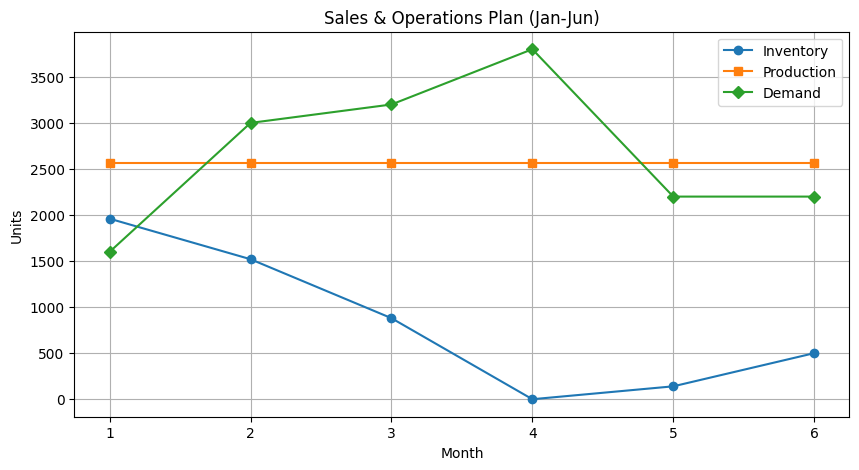

In [ ]:
# Install necessary packages (if not already installed)
!pip install gurobipy tabulate

# Import libraries
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

# Define initial demand forecast (January to June)
F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

# Number of months
n_months = len(F) - 1

# Create Gurobi model
model = Model("MinimizeCost")

# Decision variables
H = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(n_months + 1)}
L = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(n_months + 1)}
W = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(n_months + 1)}
O = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(n_months + 1)}
I = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(n_months + 1)}
S = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(n_months + 1)}
C = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(n_months + 1)}
P = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(n_months + 1)}
D = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(n_months + 1)}

# Update model
model.update()

# Objective function: Minimize total cost
model.setObjective(
    quicksum(300 * H[t] + 500 * L[t] + 640 * W[t] + 6 * O[t] + 2 * I[t] + 5 * S[t] + 30 * C[t] + 10 * P[t] for t in range(1, n_months + 1)),
    GRB.MINIMIZE
)

# Constraints
for t in range(1, n_months + 1):
    model.addConstr(W[0] == 80, name="Workforce_Beg")
    model.addConstr(W[t] - W[t - 1] - H[t] + L[t] == 0, name=f"Workforce_size_{t}")
    model.addConstr(D[t] == F[t], name=f"Demand_{t}")
    model.addConstr(I[0] == 1000, name="Starting_Inventory")
    model.addConstr(I[t - 1] + P[t] + C[t] - D[t] - S[t - 1] - I[t] + S[t] == 0, name=f"Inventory_Balance_{t}")
    model.addConstr(I[n_months] >= 500, name="Inventory_End")
    model.addConstr(S[n_months] == 0, name="Stockout_End")
    model.addConstr(40 * W[t] + O[t] / 4 - P[t] >= 0, name=f"Capacity_{t}")
    model.addConstr(10 * W[t] - O[t] >= 0, name=f"Overtime_{t}")

# Solve the model
model.optimize()

# Extract cost results
total_cost = model.objVal

# Display cost breakdown
opt_results = [[t, H[t].x, L[t].x, W[t].x, O[t].x, I[t].x, S[t].x, C[t].x, P[t].x, D[t].x] for t in range(1, n_months + 1)]
headers = ["Month", "Hired", "Laid Off", "Workforce", "Overtime", "Inventory", "Stockout", "Subcontract", "Production", "Demand"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty"))

print(f"Total Cost from Jan to June: $ {total_cost:,.2f}")

# Plot inventory, production, and demand
time_periods = list(range(1, n_months + 1))
inventory_levels = [I[t].x for t in time_periods]
production_levels = [P[t].x for t in time_periods]
demand_levels = [D[t].x for t in time_periods]

plt.figure(figsize=(10, 5))
plt.plot(time_periods, inventory_levels, marker="o", label="Inventory")
plt.plot(time_periods, production_levels, marker="s", label="Production")
plt.plot(time_periods, demand_levels, marker="D", label="Demand")
plt.xlabel("Month")
plt.ylabel("Units")
plt.title("Sales & Operations Plan (Jan-Jun)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Update demand forecast: January = 1400 (was 1600), April = 3900 (was 3800), Add July = 1200
F_updated = np.array([0, 1400, 3000, 3200, 3900, 2200, 2200, 1200])  # Now includes July

# Extra inventory in January due to lower demand (1400 instead of 1600)
extra_inventory_jan = 1600 - 1400  # 200 units extra
inventory_holding_cost_per_unit = 2  # From Gurobi model
extra_inventory_cost_jan = extra_inventory_jan * inventory_holding_cost_per_unit

# Print extra inventory cost impact
print(f"Extra Inventory in January: {extra_inventory_jan} units")
print(f"Additional Inventory Holding Cost in January: $ {extra_inventory_cost_jan:,.2f}")

# Update number of months
n_months_updated = len(F_updated) - 1

# Create a new Gurobi model with the updated forecast
model_updated = Model("Updated_S&OP")

# Define variables
H = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(n_months_updated + 1)}
L = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(n_months_updated + 1)}
W = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(n_months_updated + 1)}
O = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(n_months_updated + 1)}
I = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(n_months_updated + 1)}
S = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(n_months_updated + 1)}
C = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(n_months_updated + 1)}
P = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(n_months_updated + 1)}
D = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(n_months_updated + 1)}

# Update the model
model_updated.update()

# Objective function: Minimize total cost
model_updated.setObjective(
    quicksum(300 * H[t] + 500 * L[t] + 640 * W[t] + 6 * O[t] + 2 * I[t] + 5 * S[t] + 30 * C[t] + 10 * P[t] for t in range(1, n_months_updated + 1)),
    GRB.MINIMIZE
)

# Constraints
for t in range(1, n_months_updated + 1):
    model_updated.addConstr(W[0] == 80, name="Workforce_Beg")
    model_updated.addConstr(W[t] - W[t - 1] - H[t] + L[t] == 0, name=f"Workforce_size_{t}")
    model_updated.addConstr(D[t] == F_updated[t], name=f"Demand_{t}")
    model_updated.addConstr(I[0] == 200, name="Starting_Inventory_Feb")  # Carrying extra inventory
    model_updated.addConstr(I[t - 1] + P[t] + C[t] - D[t] - S[t - 1] - I[t] + S[t] == 0, name=f"Inventory_Balance_{t}")
    model_updated.addConstr(I[n_months_updated] >= 500, name="Inventory_End")
    model_updated.addConstr(S[n_months_updated] == 0, name="Stockout_End")
    model_updated.addConstr(40 * W[t] + O[t] / 4 - P[t] >= 0, name=f"Capacity_{t}")
    model_updated.addConstr(10 * W[t] - O[t] >= 0, name=f"Overtime_{t}")

# Solve the updated model
model_updated.optimize()

# Extract new total cost
updated_total_cost = model_updated.objVal

# Extract results for comparison
opt_results_updated = [[t, H[t].x, L[t].x, W[t].x, O[t].x, I[t].x, S[t].x, C[t].x, P[t].x, D[t].x] for t in range(1, n_months_updated + 1)]
headers = ["Month", "Hired", "Laid Off", "Workforce", "Overtime", "Inventory", "Stockout", "Subcontract", "Production", "Demand"]
print(tabulate(opt_results_updated, headers=headers, tablefmt="pretty"))

print(f"Updated Total Cost (Feb-Jul): $ {updated_total_cost:,.2f}")


Extra Inventory in January: 200 units
Additional Inventory Holding Cost in January: $ 400.00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 63 rows, 72 columns and 147 nonzeros
Model fingerprint: 0xb12a1560
Variable types: 0 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+01]
  Objective range  [2e+00, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 4e+03]
Found heuristic solution: objective 563000.00000
Presolve removed 35 rows and 30 columns
Presolve time: 0.00s
Presolved: 28 rows, 42 columns, 88 nonzeros
Variable types: 0 continuous, 42 integer (0 binary)

Root relaxation: objective 4.785750e+05, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

In [ ]:
# Given Data (Planned vs. Actual January)
planned_demand_jan = 1600  # From Step 1
actual_demand_jan = 1400  # Realized demand
extra_inventory_jan = planned_demand_jan - actual_demand_jan  # Extra inventory = 200 units

# Cost Parameters (from Gurobi model)
inventory_holding_cost_per_unit = 2  # Cost of holding inventory per unit

# Extra cost due to additional inventory
extra_inventory_cost_jan = extra_inventory_jan * inventory_holding_cost_per_unit

# Print cost impact for January
print(f"Planned January Demand: {planned_demand_jan} units")
print(f"Actual January Demand: {actual_demand_jan} units")
print(f"Extra Inventory in January: {extra_inventory_jan} units")
print(f"Additional Inventory Holding Cost in January: $ {extra_inventory_cost_jan:,.2f}")

# January's planned total cost (from Step 1)
planned_january_cost = model.objVal  # Assuming you stored the original total cost

# January's actual cost with extra inventory holding
actual_january_cost = planned_january_cost + extra_inventory_cost_jan

# Cost difference due to demand change
cost_difference_january = actual_january_cost - planned_january_cost

# Print cost impact
print(f"Planned January Cost: $ {planned_january_cost:,.2f}")
print(f"Actual January Cost (with extra inventory): $ {actual_january_cost:,.2f}")
print(f"Cost Difference due to demand change in January: $ {cost_difference_january:,.2f}")


Planned January Demand: 1600 units
Actual January Demand: 1400 units
Extra Inventory in January: 200 units
Additional Inventory Holding Cost in January: $ 400.00
Planned January Cost: $ 422,660.00
Actual January Cost (with extra inventory): $ 423,060.00
Cost Difference due to demand change in January: $ 400.00


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 54 rows, 72 columns and 126 nonzeros
Model fingerprint: 0x784cf730
Variable types: 0 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+01]
  Objective range  [2e+00, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 4e+03]
Found heuristic solution: objective 521000.00000
Presolve removed 30 rows and 36 columns
Presolve time: 0.00s
Presolved: 24 rows, 36 columns, 75 nonzeros
Variable types: 0 continuous, 36 integer (0 binary)

Root relaxation: objective 4.366750e+05, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 43667

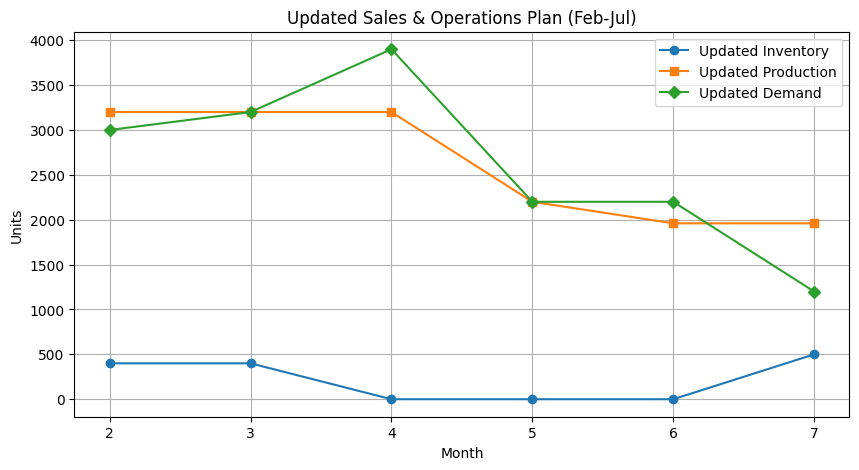

Original Total Cost (Feb-Jun): $ 422,660.00
Updated Total Cost (Feb-Jul): $ 436,720.00
Cost Difference (Feb-Jun): $ 14,060.00
+-------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
| Month | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand |
+-------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
|   2   |  0.0  |   -0.0   |   80.0    |   -0.0   |   400.0   |   -0.0   |    -0.0     |   3200.0   | 3000.0 |
|   3   |  0.0  |   -0.0   |   80.0    |   -0.0   |   400.0   |   -0.0   |     0.0     |   3200.0   | 3200.0 |
|   4   |  0.0  |   -0.0   |   80.0    |   -0.0   |   -0.0    |   20.0   |    280.0    |   3200.0   | 3900.0 |
|   5   |  0.0  |   25.0   |   55.0    |   -0.0   |   -0.0    |   20.0   |     0.0     |   2200.0   | 2200.0 |
|   6   |  0.0  |   6.0    |   49.0    |   -0.0   |   -0.0    |  260.0   |     0.0     |   1960.0

In [ ]:
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import numpy as np
from tabulate import tabulate

# Updated demand forecast (with actual January demand impact)
F_updated = np.array([0, 1400, 3000, 3200, 3900, 2200, 2200, 1200])  # Adjusted April and added July

# Start February with extra inventory from January (200 units carried over)
starting_inventory_feb = 200

# Number of months in the updated plan (Feb to Jul)
n_months_updated = len(F_updated) - 1

# Create a new Gurobi model with the updated demand and extra inventory
model_updated = Model("Updated_S&OP")

# Decision variables
H = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(n_months_updated + 1)}
L = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(n_months_updated + 1)}
W = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(n_months_updated + 1)}
O = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(n_months_updated + 1)}
I = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(n_months_updated + 1)}
S = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(n_months_updated + 1)}
C = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(n_months_updated + 1)}
P = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(n_months_updated + 1)}
D = {t: model_updated.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(n_months_updated + 1)}

# Update model
model_updated.update()

# Objective function: Minimize total cost
model_updated.setObjective(
    quicksum(300 * H[t] + 500 * L[t] + 640 * W[t] + 6 * O[t] + 2 * I[t] + 5 * S[t] + 30 * C[t] + 10 * P[t] for t in range(2, n_months_updated + 1)),
    GRB.MINIMIZE
)

# Constraints
for t in range(2, n_months_updated + 1):  # Start from Feb
    model_updated.addConstr(W[1] == 80, name="Workforce_Beg")
    model_updated.addConstr(W[t] - W[t - 1] - H[t] + L[t] == 0, name=f"Workforce_size_{t}")
    model_updated.addConstr(D[t] == F_updated[t], name=f"Demand_{t}")
    model_updated.addConstr(I[1] == starting_inventory_feb, name="Starting_Inventory_Feb")  # Extra inventory from Jan
    model_updated.addConstr(I[t - 1] + P[t] + C[t] - D[t] - S[t - 1] - I[t] + S[t] == 0, name=f"Inventory_Balance_{t}")
    model_updated.addConstr(I[n_months_updated] >= 500, name="Inventory_End")
    model_updated.addConstr(S[n_months_updated] == 0, name="Stockout_End")
    model_updated.addConstr(40 * W[t] + O[t] / 4 - P[t] >= 0, name=f"Capacity_{t}")
    model_updated.addConstr(10 * W[t] - O[t] >= 0, name=f"Overtime_{t}")

# Solve the updated model
model_updated.optimize()

# Extract new total cost
updated_total_cost = model_updated.objVal

# Extract results for plotting
time_periods = list(range(2, n_months_updated + 1))
inventory_levels_updated = [I[t].x for t in time_periods]
production_levels_updated = [P[t].x for t in time_periods]
demand_levels_updated = [D[t].x for t in time_periods]

# Plot updated S&OP plan
plt.figure(figsize=(10, 5))
plt.plot(time_periods, inventory_levels_updated, marker="o", label="Updated Inventory")
plt.plot(time_periods, production_levels_updated, marker="s", label="Updated Production")
plt.plot(time_periods, demand_levels_updated, marker="D", label="Updated Demand")
plt.xlabel("Month")
plt.ylabel("Units")
plt.title("Updated Sales & Operations Plan (Feb-Jul)")
plt.legend()
plt.grid()
plt.show()

# Compute cost difference (compare Feb-Jun from original and updated)
cost_difference = updated_total_cost - model.objVal  # Assuming `model.objVal` holds the original cost

# Print cost comparison
print(f"Original Total Cost (Feb-Jun): $ {model.objVal:,.2f}")
print(f"Updated Total Cost (Feb-Jul): $ {updated_total_cost:,.2f}")
print(f"Cost Difference (Feb-Jun): $ {cost_difference:,.2f}")

# Show updated cost breakdown table
opt_results_updated = [[t, H[t].x, L[t].x, W[t].x, O[t].x, I[t].x, S[t].x, C[t].x, P[t].x, D[t].x] for t in range(2, n_months_updated + 1)]
headers = ["Month", "Hired", "Laid Off", "Workforce", "Overtime", "Inventory", "Stockout", "Subcontract", "Production", "Demand"]
print(tabulate(opt_results_updated, headers=headers, tablefmt="pretty"))
